### Description

### load 

In [2]:
import os
import random 
import pickle
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# to import src is necessary to append the root_path to the path
#sys.path.append(root_path)

data_path = os.path.join(root_path,'data')
results_path = os.path.join(root_path,'results')

### Define global variables

In [3]:
WITH_STEMMING = True
REMOVE_STOPWORDS = True
MINIMUM_WORDS_PER_PHRASE = 0
GROUP = -1
SEED = 10
num_topics = 60
random.seed(SEED)

In [4]:
df = pd.read_excel('IBL_topic_distribution_by_utterance_with_phrase_before_and_after_time_utterance_minimum_0_words_with_stemming.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'IBL_topic_distribution_by_utterance_with_phrase_before_and_after_time_utterance_minimum_0_words_with_stemming.xlsx'

In [5]:
df.columns

NameError: name 'df' is not defined

### split dataset

In [94]:
the_keys = list(set(df['phase']))
for key in the_keys:
    n = list(df.phase.values).count(key)
    print("key {}, total {}".format(key,n))

key 1, total 474
key 2, total 209
key 3, total 477
key 4, total 70
key 5, total 653


In [97]:
trainset = {}
testset = {}
for name, group in df.groupby(['phase']):
    trainset[name]=[]
    testset[name]=[]
    n = len(group)
    ra = random.sample(range(n),int(n*0.2))
    print("test set phase {}: {}".format(name,int(n*0.2)))
    count = 0
    group = group.reset_index()
    for i,row in group.iterrows():
        if i in ra:
            count+=1
            testset[name].append(row.values)
        else:
            trainset[name].append(row.values)


test set phase 1: 94
test set phase 2: 41
test set phase 3: 95
test set phase 4: 14
test set phase 5: 130


In [98]:
filter_rows = list(range(1,181))+[188,189]
filter_labels = [180]

In [99]:
def get_data_from_dict(a_dict):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            y.append(key)
    return X,y

In [100]:
X_train,y_train = get_data_from_dict(trainset)
X_test,y_test = get_data_from_dict(testset)

In [101]:
print(y_test.count(4))
print(len(X_train[0]))

14
182


### Train decision tree


In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier(random_state=SEED).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.40


In [103]:
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

In [104]:
dot_data = tree.export_graphviz(clf, class_names=['1', '2','3','4','5'], out_file=None,max_depth=3)
graph = graphviz.Source(dot_data)
graph.render('test-output/tree_phases_5_classes.gv', view=True)

'test-output/tree_phases_5_classes.gv.pdf'

In [106]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[45 14 16  1 18]
 [ 5 14  8  1 13]
 [12 12 34  4 33]
 [ 3  3  2  0  6]
 [28 13 23  9 57]]
              precision    recall  f1-score   support

           1       0.48      0.48      0.48        94
           2       0.25      0.34      0.29        41
           3       0.41      0.36      0.38        95
           4       0.00      0.00      0.00        14
           5       0.45      0.44      0.44       130

   micro avg       0.40      0.40      0.40       374
   macro avg       0.32      0.32      0.32       374
weighted avg       0.41      0.40      0.40       374



### Train without stem

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.61
Accuracy of K-NN classifier on test set: 0.42


In [109]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[57  5 14  0 18]
 [10 15  9  0  7]
 [31  6 28  3 27]
 [ 2  3  3  0  6]
 [37 13 20  2 58]]
              precision    recall  f1-score   support

           1       0.42      0.61      0.49        94
           2       0.36      0.37      0.36        41
           3       0.38      0.29      0.33        95
           4       0.00      0.00      0.00        14
           5       0.50      0.45      0.47       130

   micro avg       0.42      0.42      0.42       374
   macro avg       0.33      0.34      0.33       374
weighted avg       0.41      0.42      0.41       374



In [110]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.24
Accuracy of GNB classifier on test set: 0.18


In [111]:
pred = gnb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 5 27 14 44  4]
 [ 5 14  6 14  2]
 [ 3 17 25 44  6]
 [ 1  2  1  9  1]
 [11 26 27 52 14]]
              precision    recall  f1-score   support

           1       0.20      0.05      0.08        94
           2       0.16      0.34      0.22        41
           3       0.34      0.26      0.30        95
           4       0.06      0.64      0.10        14
           5       0.52      0.11      0.18       130

   micro avg       0.18      0.18      0.18       374
   macro avg       0.26      0.28      0.18       374
weighted avg       0.34      0.18      0.19       374



C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [112]:
svm = SVC(decision_function_shape='ovr',gamma=1,kernel='rbf',random_state=SEED,C= 100.0)#class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.78
Accuracy of SVM classifier on test set: 0.49


In [113]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[65  3  7  0 19]
 [ 7 10  4  0 20]
 [25  3 29  1 37]
 [ 1  2  2  0  9]
 [27 10 15  0 78]]
              precision    recall  f1-score   support

           1       0.52      0.69      0.59        94
           2       0.36      0.24      0.29        41
           3       0.51      0.31      0.38        95
           4       0.00      0.00      0.00        14
           5       0.48      0.60      0.53       130

   micro avg       0.49      0.49      0.49       374
   macro avg       0.37      0.37      0.36       374
weighted avg       0.47      0.49      0.46       374



In [114]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=SEED,max_iter=3000)#,class_weight={1:0.4,2:0.4,3:0.4,4:0.5,5:0.3})
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.53
Accuracy of SVM classifier on test set: 0.50


In [115]:
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[60  2 10  0 22]
 [11  5  2  1 22]
 [26  0 30  0 39]
 [ 1  0  3  0 10]
 [30  5  4  0 91]]
              precision    recall  f1-score   support

           1       0.47      0.64      0.54        94
           2       0.42      0.12      0.19        41
           3       0.61      0.32      0.42        95
           4       0.00      0.00      0.00        14
           5       0.49      0.70      0.58       130

   micro avg       0.50      0.50      0.50       374
   macro avg       0.40      0.36      0.35       374
weighted avg       0.49      0.50      0.46       374



### Optimize params

In [81]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(random_state=SEED), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


The best parameters are {'C': 1000000.0, 'gamma': 1e-05} with a score of 0.51


In [88]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 1000000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.80
Accuracy of SVM classifier on test set: 0.78


In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[264  16]
 [ 68  26]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       280
           1       0.62      0.28      0.38        94

   micro avg       0.78      0.78      0.78       374
   macro avg       0.71      0.61      0.62       374
weighted avg       0.75      0.78      0.74       374



### Build classifier per class

In [84]:
def get_data_from_dict_filter(a_dict,filter_phase):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            if filter_phase == key:
                y.append(key)
            else:
                y.append(0)
    return X,y

### classify class 1

In [85]:
#trainset,testset = split_sets_key(clean_phrases,1)
X_train,y_train = get_data_from_dict_filter(trainset,1)
X_test,y_test = get_data_from_dict_filter(testset,1)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [87]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.75
Accuracy of SVM classifier on test set: 0.70
[[206  74]
 [ 37  57]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       280
           1       0.44      0.61      0.51        94

   micro avg       0.70      0.70      0.70       374
   macro avg       0.64      0.67      0.65       374
weighted avg       0.74      0.70      0.72       374



### classify class 2

In [58]:
trainset,testset = split_sets_key(clean_phrases,2)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [59]:
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.97
Accuracy of SVM classifier on test set: 0.85


In [60]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[310  27]
 [ 31  11]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       337
           2       0.29      0.26      0.28        42

   micro avg       0.85      0.85      0.85       379
   macro avg       0.60      0.59      0.59       379
weighted avg       0.84      0.85      0.84       379



### Classify class 3

In [61]:
trainset,testset = split_sets_key(clean_phrases,3)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)

In [62]:
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.94
Accuracy of SVM classifier on test set: 0.72
[[238  45]
 [ 61  35]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       283
           3       0.44      0.36      0.40        96

   micro avg       0.72      0.72      0.72       379
   macro avg       0.62      0.60      0.61       379
weighted avg       0.71      0.72      0.71       379



### Classify class 4

In [63]:
trainset,testset = split_sets_key(clean_phrases,3)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.94
Accuracy of SVM classifier on test set: 0.72
[[232  51]
 [ 54  42]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       283
           3       0.45      0.44      0.44        96

   micro avg       0.72      0.72      0.72       379
   macro avg       0.63      0.63      0.63       379
weighted avg       0.72      0.72      0.72       379



### classify class 5

In [64]:
trainset,testset = split_sets_key(clean_phrases,5)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)
print(y_train.count(0)*100.0/len(y_train))

65.20314547837484


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [66]:
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=SEED)#,class_weight={5:0.7,0:0.3})#,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.91
Accuracy of SVM classifier on test set: 0.58


In [67]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[180  67]
 [ 92  40]]
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       247
           5       0.37      0.30      0.33       132

   micro avg       0.58      0.58      0.58       379
   macro avg       0.52      0.52      0.51       379
weighted avg       0.56      0.58      0.57       379



#### Regression


In [70]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,class_weight={0:0.36,5:0.63}).fit(X_train, y_train)

In [71]:
clf.predict_proba(X_test)

array([[0.48809521, 0.51190479],
       [0.47908077, 0.52091923],
       [0.54688779, 0.45311221],
       [0.50150163, 0.49849837],
       [0.53557416, 0.46442584],
       [0.54171687, 0.45828313],
       [0.53040496, 0.46959504],
       [0.52168871, 0.47831129],
       [0.55859212, 0.44140788],
       [0.53143153, 0.46856847],
       [0.50047013, 0.49952987],
       [0.45217879, 0.54782121],
       [0.50560881, 0.49439119],
       [0.51346373, 0.48653627],
       [0.48517514, 0.51482486],
       [0.53966207, 0.46033793],
       [0.52190952, 0.47809048],
       [0.52508409, 0.47491591],
       [0.50422179, 0.49577821],
       [0.48598265, 0.51401735],
       [0.52190851, 0.47809149],
       [0.48753983, 0.51246017],
       [0.54060426, 0.45939574],
       [0.52190952, 0.47809048],
       [0.45897801, 0.54102199],
       [0.54688779, 0.45311221],
       [0.56737279, 0.43262721],
       [0.55260755, 0.44739245],
       [0.54688779, 0.45311221],
       [0.5319106 , 0.4680894 ],
       [0.

In [47]:
len(X_train)

778

In [73]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[188  59]
 [ 75  57]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       247
           5       0.49      0.43      0.46       132

   micro avg       0.65      0.65      0.65       379
   macro avg       0.60      0.60      0.60       379
weighted avg       0.64      0.65      0.64       379



In [48]:
sum(clf.coef_[0])

0.04929037263788723

In [55]:
clf.classes_

array([0, 5], dtype=int64)

In [54]:
clf.predict_proba(X_test)

array([[0.51722492, 0.48277508],
       [0.51802061, 0.48197939],
       [0.48140675, 0.51859325],
       [0.43863162, 0.56136838],
       [0.48832214, 0.51167786],
       [0.50338065, 0.49661935],
       [0.49807092, 0.50192908],
       [0.48768827, 0.51231173],
       [0.51940268, 0.48059732],
       [0.50682786, 0.49317214],
       [0.53835118, 0.46164882],
       [0.50396708, 0.49603292],
       [0.49456355, 0.50543645],
       [0.48788069, 0.51211931],
       [0.49864388, 0.50135612],
       [0.50588767, 0.49411233],
       [0.46784628, 0.53215372],
       [0.5014208 , 0.4985792 ],
       [0.5039747 , 0.4960253 ],
       [0.512218  , 0.487782  ],
       [0.49972879, 0.50027121],
       [0.50298627, 0.49701373],
       [0.4973704 , 0.5026296 ],
       [0.48707633, 0.51292367],
       [0.49860459, 0.50139541],
       [0.49349256, 0.50650744],
       [0.50527679, 0.49472321],
       [0.47977555, 0.52022445],
       [0.52144721, 0.47855279],
       [0.46241811, 0.53758189],
       [0.

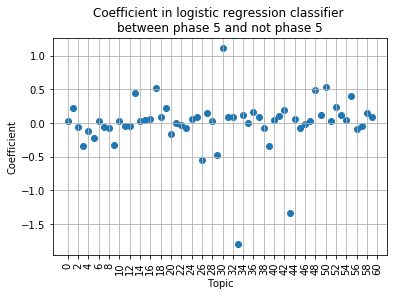

In [74]:
plt.scatter(range(len(clf.coef_[0])),clf.coef_[0])
plt.xticks(range(0,len(clf.coef_[0])+1,2),rotation=90)
plt.xlabel('Topic')
plt.ylabel('Coefficient')
plt.title('Coefficient in logistic regression classifier \nbetween phase 5 and not phase 5')
plt.grid()

In [28]:
ldamodel.show_topic(47)

[('sähkövir', 0.08063437),
 ('kytk', 0.029709047),
 ('sarj', 0.018370252),
 ('lait', 0.017849041),
 ('komponent', 0.015947282),
 ('sähkömoottor', 0.01339101),
 ('sähkölait', 0.012932554),
 ('eli', 0.0125470385),
 ('raken', 0.012349038),
 ('laite', 0.0113198925)]

In [188]:
np.std(clf.coef_[0])

0.3111038067516104

In [189]:
np.mean(clf.coef_[0])

0.0005360692171084533

In [110]:
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)

In [80]:
len(a[0])

60

In [115]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = get_topic_distribution(trainset)#make_blobs(n_samples=1000, centers=centers, random_state=40)
#transformation = [[0.4, 0.2], [-0.4, 1.2]]
#X = np.dot(X, transformation)
pca = PCA(n_components=20)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [114]:
len(X)

1905

In [116]:
v_1 = pca.components_[0]
v_2 = pca.components_[1]

In [117]:
pca.components_

array([[-0.01142853, -0.00731208,  0.00909848, ..., -0.00595645,
        -0.00731979,  0.01270913],
       [ 0.00438504,  0.01574188, -0.00982099, ..., -0.00363591,
        -0.0088206 , -0.01543635],
       [-0.00066237,  0.00652247,  0.00300619, ..., -0.00666595,
        -0.00543397,  0.0061896 ],
       ...,
       [ 0.04354618, -0.04109778, -0.11646606, ..., -0.0322638 ,
        -0.01654347,  0.23272723],
       [-0.02016083,  0.01519194,  0.06609278, ..., -0.03702898,
         0.03868529, -0.34274174],
       [-0.03794056, -0.12599665,  0.15772072, ...,  0.02085024,
         0.05684396, -0.21580076]])

In [118]:
len(pca.components_)

20

In [20]:
Xdot = np.dot(X,pca.components_.T)

NameError: name 'pca' is not defined

In [105]:
colors = {1:'r',2:'b',3:'g',4:'y',5:'black'}


In [19]:
Xdot

NameError: name 'Xdot' is not defined

In [106]:
color_label = [colors[i] for i in y]
plt.scatter(Xdot,color=color_label)

TypeError: scatter() missing 1 required positional argument: 'y'

In [97]:
X_dot = np.array(list(map(lambda x: np.dot(v_1,x),X)))

In [106]:
plt.scatter(X_dot,Y_dot,color=)

754

In [138]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 0  0  0 49]
 [ 0  0  0 27]
 [ 1  0  8 29]
 [ 0  0  3 69]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        27
           3       0.73      0.21      0.33        38
           5       0.40      0.96      0.56        72

   micro avg       0.41      0.41      0.41       186
   macro avg       0.28      0.29      0.22       186
weighted avg       0.30      0.41      0.28       186



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    X_dot = np.array(list(map(lambda x: np.dot(v_1,x),X)))
    Y_dot = np.array(list(map(lambda x: np.dot(v_2,x),X)))
    x_min, x_max = X_dot.min() - 1, X_dot.max() + 1
    y_min, y_max = Y_dot.min() - 1, Y_dot.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

training score : 0.415 (multinomial)


ValueError: X has 2 features per sample; expecting 60

In [ ]:
lda.